# Forecasting Prediction Using XGBoost Model

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import holidays

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Data Exploration

In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df = df.set_index('date')

*seasonal_decompose*

<Figure size 432x288 with 0 Axes>

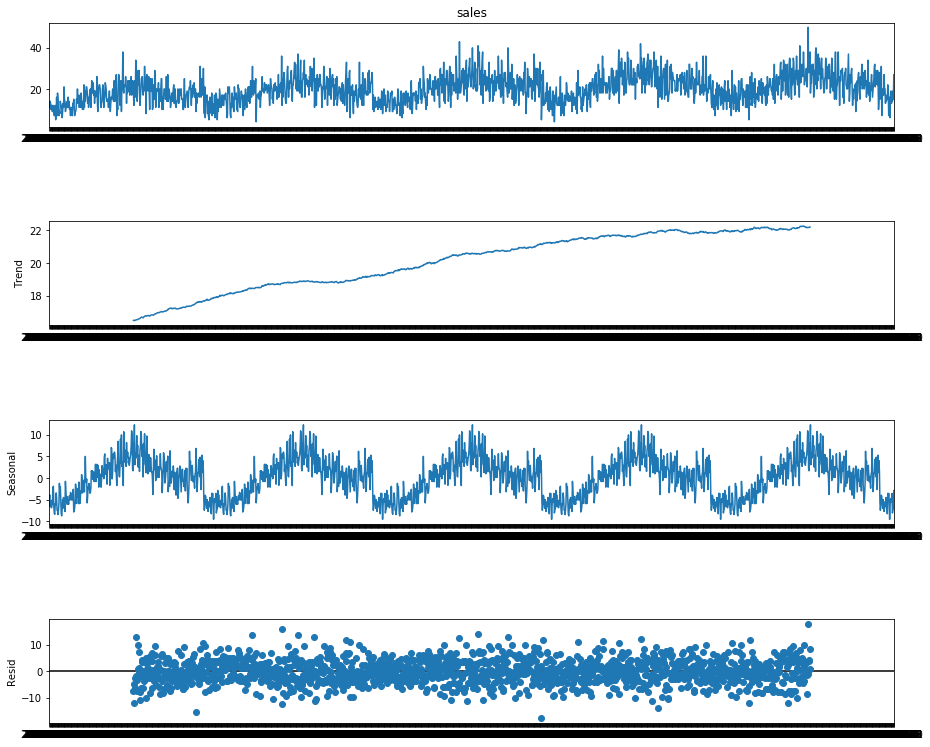

In [4]:
sample = df[df['store'] == 1]
sample = sample[sample['item'] == 1]
sample = sample.set_index('date')

result = seasonal_decompose(sample['sales'], model='additive', period = 365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Data Preparation

### Handling Missing Values

*dataframe.interpolate()*

### Handling Outliers

Outliers are usually caused by two reasons:
* Mistakes and Errors 
* Exceptional Demand

In [5]:
# Function for removing outliers


## Feature Engineering

In this section we will generate additional feature categories to provide more insight for the machine learning algorithm:

* Date Time Features
* Lag/Shifted Features
* Rolling Window Statistics
* Expanding Window Statistics

### Date Time Features

Time-Related features are features generated by the timestap of each observation.

Generated these additional time-related features can provide insights to improve your model.

For example you could use the timestamp and generate a feature called *is_holiday* which tells you whether that day is a holiday or not. From this feature you might see that sales are higher on holidays.

In [6]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
def holiday_list(df):
    
    df['date'] = pd.to_datetime(df.date)
    min_year = df.date.min().year
    max_year = df.date.max().year
    
    years_list = pd.period_range(min_year, max_year, freq = 'Y')
    list_of_holidays = []
    
    for year in years_list:
        list_of_holidays.append(holidays.US(years = int(str(year))).keys())
        
    holiday_list = [item for sublist in list_of_holidays for item in sublist]
    
    return holiday_list

In [8]:
def create_date_time_features(df):
    df['date'] = pd.to_datetime(df.date)
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.weekday + 1
    df['year'] = df.date.dt.year 
    df['is_weekend'] = df.date.dt.weekday // 5
    df['start_of_month'] = df.date.dt.is_month_start.astype(int)
    df['end_of_month'] = df.date.dt.is_month_end.astype(int)
    df['is_holiday'] = np.where(df.date.isin(holiday_list(df)), 1, 0)
    
    return df

In [9]:
df = create_date_time_features(df)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,start_of_month,end_of_month,is_holiday
0,2013-01-01,1,1,13,1,1,1,1,2,2013,0,1,0,1
1,2013-01-02,1,1,11,1,2,2,1,3,2013,0,0,0,0
2,2013-01-03,1,1,14,1,3,3,1,4,2013,0,0,0,0
3,2013-01-04,1,1,13,1,4,4,1,5,2013,0,0,0,0
4,2013-01-05,1,1,10,1,5,5,1,6,2013,1,0,0,0


### Lag/Shifted Features

Lag features are useful because the value observed at time $t$ is highly dependent on the value observed at time $t-1$

We are telling the model to look back into the past however many days we specify and to use the sales value in the past as a new feature.

In [10]:
lag_list = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
            182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
            365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
            730, 800, 900, 950, 990, 1000, 1050, 1090, 1095]

def create_lag_features(df, lag_list):
    for lag in lag_list:
        df['lag' + str(lag)] = df.groupby(["store", "item"]).sales.shift(lag)
    return df

In [11]:
df = create_lag_features(df, lag_list)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,lag728,lag730,lag800,lag900,lag950,lag990,lag1000,lag1050,lag1090,lag1095
0,2013-01-01,1,1,13,1,1,1,1,2,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,1,2,2,1,3,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,1,3,3,1,4,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,1,4,4,1,5,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,1,5,5,1,6,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of NaN values in the beginning of the dataset. This is because we're looking back on data that does not exist.

### Rolling Mean/Moving Average

How rolling mean works is that you input a window of time and calculate the average or mean demand of that time period.

In [12]:
windows_list = [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]

def create_rolling_mean_features(df, windows_list):
    for window in windows_list:
        df['sales_rolling_mean' + str(window)] = df.groupby(["store", "item"]).sales.rolling(window).mean().shift(1).values
    return df

In [13]:
df = create_rolling_mean_features(df, windows_list)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,sales_rolling_mean119,sales_rolling_mean126,sales_rolling_mean186,sales_rolling_mean200,sales_rolling_mean210,sales_rolling_mean250,sales_rolling_mean300,sales_rolling_mean365,sales_rolling_mean546,sales_rolling_mean700
0,2013-01-01,1,1,13,1,1,1,1,2,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,1,2,2,1,3,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,1,3,3,1,4,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,1,4,4,1,5,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,1,5,5,1,6,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exponentially Weight Mean Features

This feature applies weight to the time series values. More recent values will have a larger weight applied to it. This is because more recent points will be more relevant for future forecasts.

In [14]:
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
alpha_list = [0.95, 0.9, 0.8, 0.7, 0.5]

def create_exp_weight_mean_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".","") + 
              "_lag_" + str(lag)] = df.groupby(["store", "item"]).sales.transform(
            lambda x: x.shift(lag).ewm(alpha = alpha).mean())
    return df

In [15]:
df = create_exp_weight_mean_features(df, alpha_list, lags)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13,1,1,1,1,2,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,1,2,2,1,3,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,1,3,3,1,4,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,1,4,4,1,5,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,1,5,5,1,6,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [17]:
# df['sales'] = np.log1p(df["sales"].values)


## Error Metric

In [18]:
# columns with no useful information or with information that is already derived will be dropped.

cols = [col for col in df.columns if col not in ['date', 'id', "sales", "year"]]

In [19]:
X = df[cols]
Y = df['sales']

In [20]:
X.head()

,day_of_month,day_of_year,week_of_year,is_weekend,start_of_month,end_of_month,is_holiday,lag91,lag92,lag93,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,0,1,0,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,2,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3,3,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,4,4,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,5,5,1,1,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Y.head()

0    13
1    11
2    14
3    13
4    10
Name: sales, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [23]:
# train = df.loc[(df["date"] < "2017-01-01"), :]
# val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [24]:
# Y_train = train['sales']
# XG
# Y_val = val['sales']
# X_val = val[cols]

## XGBoost Model

LightGBM is a tree-based gradient boosting framework. It is designed for speed and efficiency.

In [25]:
model = xgb.XGBRegressor()

In [26]:
model.fit(X_train, y_train,
         eval_set = [(X_val, y_val)],
         verbose = True,
         eval_metric = 'rmse',
         early_stopping_rounds = 20)

[18:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.6746
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:48.6554
[2]	validation_0-rmse:44.157
[3]	validation_0-rmse:40.1311
[4]	validation_0-rmse:36.5256
[5]	validation_0-rmse:33.302
[6]	validation_0-rmse:30.4236
[7]	validation_0-rmse:27.871
[8]	validation_0-rmse:25.5909
[9]	validation_0-rmse:23.5648
[10]	validation_0-rmse:21.7832
[11]	validation_0-rmse:20.2011
[12]	validation_0-rmse:18.7931
[13]	validation_0-rmse:17.562
[14]	validation_0-rmse:16.4878
[15]	validation_0-rmse:15.548
[16]	validation_0-rmse:14.7331
[17]	validation_0-rmse:14.0303
[18]	validation_0-rmse:13.4238
[19]	validation_0-rmse:12.9023
[20]	validation_0-rmse:12.4479
[21]	validation_0-rmse:12.0668
[22]	validation_0-rmse:11.7161
[23]	validation_0-rmse:11.4199
[24]	validation_0-rmse:11.164
[25]	validation_0-rmse:10.9561
[26]	validation_0-rmse:10.757

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
predictions = model.predict(X_test)

In [33]:
predictions

array([66.43155 , 18.980389, 18.625652, ..., 90.175285, 40.58848 ,
       33.354633], dtype=float32)

In [32]:
y_test.values

array([58, 22, 17, ..., 78, 38, 22])

Text(0.5, 1.0, 'XGBoost Prediction')

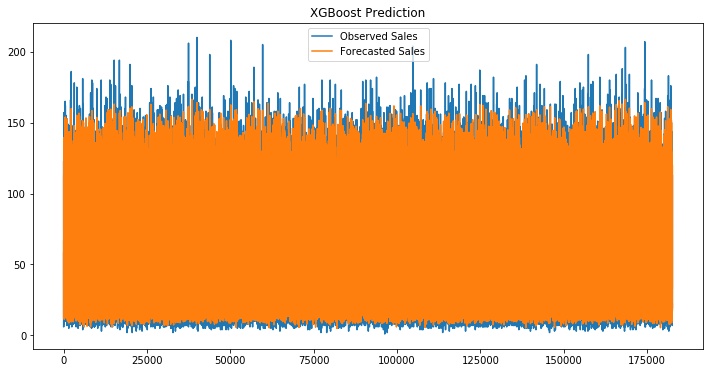

In [35]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(y_test.values, label = 'Observed Sales')
forecast = plt.plot(predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("XGBoost Prediction")

In [37]:
print('XGBoost RMSE = ', mean_squared_error(predictions, y_test.values, 
                                           squared = False))

XGBoost RMSE =  8.758140786594712
